In [2]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import time

import seaborn
from matplotlib import pyplot

from sklearn.linear_model import LogisticRegression

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [5]:
chess_games_cut = pd.read_csv('dist_cut.csv')

In [6]:
#FINAL CLEANING
#split the time control into two columns - Base and Incremental
time_control_df = chess_games_cut.TimeControl.apply(lambda x: pd.Series(str(x).split("+")))

time_control_df = time_control_df.rename(columns={0:"Base", 1:"Increment"})
display(time_control_df)

#Join chess games 10% cut df with time control split df together
chess_games_tc_split = pd.concat([chess_games_cut, time_control_df], axis=1)
print(chess_games_tc_split.dtypes)

#removing first column which has row numbers only; dropping TimeControl column
chess_games_tc_split = chess_games_tc_split.iloc[:,1:]
chess_games_tc_split = chess_games_tc_split.drop(columns = 'TimeControl')

#converting 'Base' to minutes in floats and 'Increment' in ints
chess_games_tc_split['Base'] = chess_games_tc_split['Base'].astype(int) / 60
#chess_games_tc_split['Base'] = chess_games_tc_split['Base'] / 60
chess_games_tc_split['Increment'] = chess_games_tc_split['Increment'].astype(int)

#renaming Base and Increment columns with units
chess_games_tc_split = chess_games_tc_split.rename(columns = {'Base': 'Base (min)', 'Increment': 'Increment (sec)'})

#checking for data types of each column
print(chess_games_tc_split.dtypes)
display(chess_games_tc_split)

#saving a csv file of the cleaned data frame
chess_games_tc_split.to_csv('chess_games_cleaned.csv')

,Base,Increment
0,300,5
1,300,0
2,180,0
3,180,0
4,180,0
...,...,...
621585,60,0
621586,300,0
621587,300,4
621588,180,0


Unnamed: 0          int64
Event              object
Result             object
WhiteElo            int64
BlackElo            int64
WhiteRatingDiff     int64
ECO                object
Opening            object
TimeControl        object
Termination        object
Base               object
Increment          object
dtype: object
Event               object
Result              object
WhiteElo             int64
BlackElo             int64
WhiteRatingDiff      int64
ECO                 object
Opening             object
Termination         object
Base (min)         float64
Increment (sec)      int64
dtype: object


,Event,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,Termination,Base (min),Increment (sec)
0,Classical,1-0,1901,1896,5,D10,Slav Defense,Time forfeit,5.0,5
1,Blitz,0-1,1641,1627,14,C20,King's Pawn Opening: 2.b3,Normal,5.0,0
2,Blitz tournament,1-0,1647,1688,-41,B01,Scandinavian Defense: Mieses-Kotroc Variation,Time forfeit,3.0,0
3,Blitz tournament,0-1,1945,1900,45,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",Time forfeit,3.0,0
4,Blitz tournament,0-1,1773,1809,-36,C27,Vienna Game,Normal,3.0,0
...,...,...,...,...,...,...,...,...,...,...
621585,Bullet tournament,0-1,1798,1753,45,B06,Modern Defense,Time forfeit,1.0,0
621586,Blitz,0-1,1711,1578,133,B08,Pirc Defense: Classical Variation,Normal,5.0,0
621587,Blitz,1-0,1762,1683,79,C00,St. George Defense,Normal,5.0,4
621588,Blitz,1-0,2023,1742,281,A45,Indian Game,Normal,3.0,0


In [7]:
#Importing final cleaned csv file
chess_games = pd.read_csv('chess_games_cleaned.csv')
chess_games = chess_games.iloc[:,1:]
print(display(chess_games))

,Event,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,Termination,Base (min),Increment (sec)
0,Classical,1-0,1901,1896,5,D10,Slav Defense,Time forfeit,5.0,5
1,Blitz,0-1,1641,1627,14,C20,King's Pawn Opening: 2.b3,Normal,5.0,0
2,Blitz tournament,1-0,1647,1688,-41,B01,Scandinavian Defense: Mieses-Kotroc Variation,Time forfeit,3.0,0
3,Blitz tournament,0-1,1945,1900,45,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",Time forfeit,3.0,0
4,Blitz tournament,0-1,1773,1809,-36,C27,Vienna Game,Normal,3.0,0
...,...,...,...,...,...,...,...,...,...,...
621585,Bullet tournament,0-1,1798,1753,45,B06,Modern Defense,Time forfeit,1.0,0
621586,Blitz,0-1,1711,1578,133,B08,Pirc Defense: Classical Variation,Normal,5.0,0
621587,Blitz,1-0,1762,1683,79,C00,St. George Defense,Normal,5.0,4
621588,Blitz,1-0,2023,1742,281,A45,Indian Game,Normal,3.0,0


None


In [8]:
#Summary Statistics and Descriptive Statistics
print(display(chess_games.describe()))

,WhiteElo,BlackElo,WhiteRatingDiff,Base (min),Increment (sec)
count,621590.00000,621590.000000,621590.000000,621590.000000,621590.000000
mean,1744.72006,1743.198184,1.521876,5.262023,1.200261
std,264.41607,265.945436,202.273430,6.636514,4.159368
min,784.00000,728.000000,-1569.000000,0.000000,0.000000
25%,1563.00000,1560.000000,-104.000000,2.000000,0.000000
50%,1745.00000,1743.000000,1.000000,4.000000,0.000000
75%,1922.00000,1922.000000,107.000000,6.000000,1.000000
max,3006.00000,3069.000000,1469.000000,180.000000,180.000000


None


Returning data to local variable top_ten_popular_openings
Returning data to local variable top_ten_won_openings


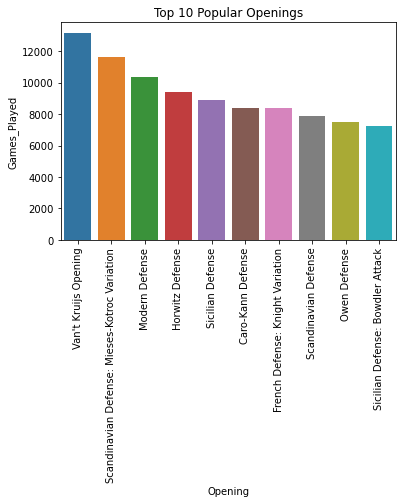

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Scandinavian Defense: Mieses-Kotroc Variation'),
  Text(1, 0, "Van't Kruijs Opening"),
  Text(2, 0, 'Modern Defense'),
  Text(3, 0, 'Horwitz Defense'),
  Text(4, 0, 'French Defense: Knight Variation'),
  Text(5, 0, 'Owen Defense'),
  Text(6, 0, 'Caro-Kann Defense'),
  Text(7, 0, 'Scandinavian Defense'),
  Text(8, 0, 'Sicilian Defense'),
  Text(9, 0, 'Philidor Defense #3')])

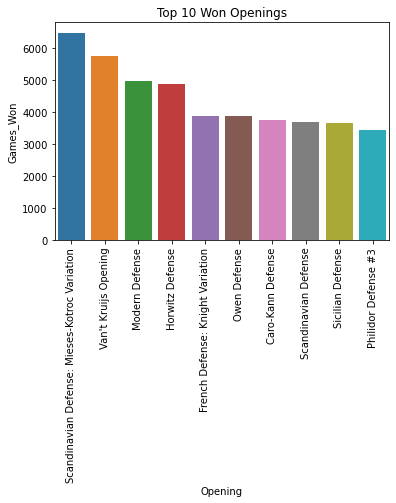

In [10]:
#Top 10 popular openings & top 10 won openings
%sql top_ten_popular_openings << SELECT Opening, COUNT(Event) As Games_Played \
FROM chess_games GROUP BY Opening ORDER BY Games_Played DESC LIMIT 10
%sql top_ten_won_openings << SELECT Opening, COUNT(Event) AS Games_Won \
FROM chess_games WHERE Result = '1-0' GROUP BY Opening ORDER BY Games_Won DESC LIMIT 10

#plotting the top 
seaborn.barplot(data = top_ten_popular_openings, x = 'Opening', y = 'Games_Played').set(title = 'Top 10 Popular Openings')
pyplot.xticks(rotation = 90)
pyplot.show()
seaborn.barplot(data = top_ten_won_openings, x = 'Opening', y = 'Games_Won').set(title = 'Top 10 Won Openings')
pyplot.xticks(rotation = 90)

In [39]:
#adding win rate column for each opening

#all openings with corresponding number of games played
%sql opening_games_played << SELECT Opening, COUNT(Event) As Games_Played \
FROM chess_games GROUP BY Opening ORDER BY Games_Played DESC

print(opening_games_played)

#all openings with corresponding number of games won
%sql opening_games_won << SELECT Opening, COUNT(Event) AS Games_Won \
FROM chess_games WHERE Result = '1-0' GROUP BY Opening ORDER BY Games_Won DESC

print(opening_games_won)

#joining games played and games won by opening
%sql opening_games << SELECT opening_games_played.Opening, Games_Played, Games_Won \
FROM opening_games_played LEFT JOIN opening_games_won \
ON opening_games_played.Opening = opening_games_won.Opening ORDER BY Games_Played DESC

#drop NaNs --> NaNs in Games_Won column indicate that opening has 0 games won
opening_games.dropna()

#filter for openings that have at least 50 games played
opening_games = opening_games[opening_games['Games_Played'] >= 50]

#compute win rate column and sort by win rate
opening_games['Win_Rate'] = opening_games['Games_Won'] / opening_games['Games_Played']
opening_win_rate = opening_games.sort_values(by = ['Win_Rate'], ascending = False)

#drop columns Games_Played and Games_Won; rename Opening to Opening_Type for later merging
opening_win_rate = opening_win_rate.drop(columns = ['Games_Played', 'Games_Won'])
opening_win_rate = opening_win_rate.rename(columns={'Opening': 'Opening_Type'})

display(opening_win_rate)

Returning data to local variable opening_games_played
                                                Opening  Games_Played
0                                  Van't Kruijs Opening         13161
1         Scandinavian Defense: Mieses-Kotroc Variation         11614
2                                        Modern Defense         10334
3                                       Horwitz Defense          9408
4                                      Sicilian Defense          8881
...                                                 ...           ...
2618  Italian Game: Classical Variation, Alexandre G...             1
2619  Queen's Gambit Accepted: Classical Defense, Al...             1
2620  Dutch Defense: Classical Variation, Stonewall ...             1
2621  Vienna Game: Hamppe-Allgaier Gambit, Alapin Va...             1
2622  Queen's Gambit Declined: Orthodox Defense, Rau...             1

[2623 rows x 2 columns]
Returning data to local variable opening_games_won
                              

,Opening_Type,Win_Rate
614,"Italian Game: Two Knights Defense, Knight Attack",0.790850
932,Indian Game: Normal Variation,0.772727
736,"Italian Game: Two Knights Defense, Max Lange A...",0.735849
946,Scandinavian Defense: Anderssen Counterattack,0.734375
880,Italian Game: Scotch Gambit Declined,0.733333
...,...,...
1048,Nimzowitsch Defense: Scandinavian Variation,0.326923
685,"Queen's Pawn Opening: Veresov, Richter Attack",0.322314
70,King's Pawn Game,0.321090
805,"Sicilian Defense: Sozin Attack, Leonhardt Vari...",0.311111


In [40]:
#adding win rate to individual games data frame
%sql chess_games_rate << SELECT * FROM chess_games LEFT JOIN opening_win_rate \
ON chess_games.Opening = opening_win_rate.Opening_Type

chess_games_rate = chess_games_rate.drop(columns = ['Opening_Type'])
display(chess_games_rate)

Returning data to local variable chess_games_rate


,Event,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,Termination,Base (min),Increment (sec),Win_Rate
0,Classical,1-0,1901,1896,5,D10,Slav Defense,Time forfeit,5.0,5,0.490376
1,Blitz,0-1,1641,1627,14,C20,King's Pawn Opening: 2.b3,Normal,5.0,0,0.412060
2,Blitz tournament,1-0,1647,1688,-41,B01,Scandinavian Defense: Mieses-Kotroc Variation,Time forfeit,3.0,0,0.558550
3,Blitz tournament,0-1,1945,1900,45,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",Time forfeit,3.0,0,0.444695
4,Blitz tournament,0-1,1773,1809,-36,C27,Vienna Game,Normal,3.0,0,0.579278
...,...,...,...,...,...,...,...,...,...,...,...
621585,Bullet tournament,0-1,1798,1753,45,B06,Modern Defense,Time forfeit,1.0,0,0.480550
621586,Blitz,0-1,1711,1578,133,B08,Pirc Defense: Classical Variation,Normal,5.0,0,0.457798
621587,Blitz,1-0,1762,1683,79,C00,St. George Defense,Normal,5.0,4,0.539982
621588,Blitz,1-0,2023,1742,281,A45,Indian Game,Normal,3.0,0,0.450352


In [42]:
#correlation between Elo rating differential and win rate
chess_games_rate[['WhiteRatingDiff','Win_Rate']].corr()

#correlation between opening played and win rate

#histograms, scatterplots

#covariance

,WhiteRatingDiff,Win_Rate
WhiteRatingDiff,1.000000,0.161571
Win_Rate,0.161571,1.000000
